In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchsummary import summary
#from scipy.spatial.distance import canberra, euclidean

#from torchpairwise import canberra_distances

import my_utility as mu

Pytorch training pipeline
1. Design model (input size, output size, forward pass and operations/layers)
2. Construct loss and optimizer
3. Training loop
    - forward pass: compute prediction
    - backward pass: get gradients
    - update weights
    - iterate until "done"

# Setup

In [3]:
# Parametri della rete
epochs = 10
batch_size = 16
learning_rate = 0.01

# Dimensione codifica frattale
n = 384

In [4]:
# Selezione del device da usare per il training
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [5]:
# Parametri del dataset
num_samples_train = 8000
num_samples_val = 2000
num_samples_test = 2000

In [6]:
# Inizializzazione
# Path a cartelle di immagini e file di embeddings
root_dir = ".\img_celeba_10000"

train_img_dir = root_dir + "\img_celeba_10000_train"
train_codify_dir = root_dir + "\codify_celeba_10000_train.csv"

valid_img_dir = root_dir + "\img_celeba_10000_valid"
valid_codify_dir = root_dir + "\codify_celeba_10000_valid.csv"

test_img_dir = root_dir + "\img_celeba_2000_test"
test_codify_dir = root_dir + "\codify_celeba_2000_test.csv"


# Caricamento datasets
train_set = mu.ImageDataSet(img_dir=train_img_dir, codify_dir=train_codify_dir)
valid_set = mu.ImageDataSet(img_dir=valid_img_dir, codify_dir=valid_codify_dir)
test_set = mu.ImageDataSet(img_dir=test_img_dir, codify_dir=test_codify_dir)

Data loaded.
Data loaded.
Data loaded.


In [7]:
# DataLoaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [8]:
# Test per verificare il corretto funzionamento
#train_features, train_labels = next(iter(train_loader))
#print(f"Feature batch shape: {train_features.size()}")
#print(f"Labels batch shape: {train_labels.size()}")
#img = train_features[0].squeeze()
#label = train_labels[0]
#plt.imshow(img, cmap="gray")
#plt.show()
#print(f"Label: {label}")

# Appunti

Architettura rete
    seq_modules = nn.Sequential(
        nn.BatchNorm2d(num_features=128),
        nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(5, 5)),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=(2, 2)),
        nn.Conv2d(in_channels=4, out_channels=16, kernel_size=(5, 5)),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=(2, 2)),
        nn.Flatten(),
        nn.BatchNorm2d(),
        nn.Linear(),
        nn.Tanh()            
    )

nn.Conv2d():
- in_channels: numero di canali in input. Dato che le immagini vengono convertite in scala di grigio, avremo un solo canale
- out_channels: numero di canali in output.


La formula per calcolare l'output del pooling è data da
$$output_{width} = \frac{W-F+2*P}{S}+1$$

dove
- W è la dimensione dell'immagine (es. W=128 se l'immagine è 124x124)
- F è la dimnesione del kernel (es. F=2 se il kernel è 2x2)
- P è il padding (dalla documentazione, "implicit zero padding to be added on both sides")
- S è lo stride, di default uguale al kernel size F

Se S è 2, la dimensione del tensore viene dimezzata (es. da 124x124 a 62x62)

# Model instance

In [9]:
model = mu.SiameseNeuralNetwork().to(device)

In [10]:
summary(model, input_size=(1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [-1, 1, 128, 128]               2
            Conv2d-2          [-1, 4, 124, 124]             104
         AvgPool2d-3            [-1, 4, 62, 62]               0
            Conv2d-4           [-1, 16, 58, 58]           1,616
         AvgPool2d-5           [-1, 16, 29, 29]               0
       BatchNorm1d-6                [-1, 13456]          26,912
            Linear-7                  [-1, 384]       5,167,488
Total params: 5,196,122
Trainable params: 5,196,122
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 1.33
Params size (MB): 19.82
Estimated Total Size (MB): 21.21
----------------------------------------------------------------


# Training

## Training function

In [11]:
def train(model, optimizer, loss_fn, train_loader, val_loader, test_loader, epochs, device):
    training_loss_list = list()
    validation_loss_list = list()
    
    for epoch in range(epochs):
        training_loss = 0.0
        validation_loss = 0.0
        
        # Training loop
        model.train()
        for batch in train_loader:
            inputs, label = batch
            inputs = inputs.to(device)
            label = label.to(device)

            # Calcolo dell'embedding di output
            output = model(inputs)
            
            # Confronto con l'embedding di input
            loss = loss_fn(output, label)
            loss.requires_grad = True
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            training_loss += loss.data.item()
        training_loss_list.append(training_loss)
        
        
        # Validation loop
        model.eval()
        for batch in val_loader:
            inputs, labels = batch

            inputs = inputs.to(device)
            output = model(inputs)
            labels = labels.to(device)
            loss = loss_fn(output, labels)
            
            validation_loss += loss.data.item()
        validation_loss_list.append(validation_loss)
        
        print(f"Epoch [{epoch+1}/{epochs}] ----> \nTraining loss: {training_loss:.4f} \nValidation loss: {validation_loss:.4f}\n")
    

    # Loss on random test batch
    test_images, test_labels = next(iter(test_loader))
    #test_sample = test_images
    #test_label = test_labels

    test_images = test_images.to(device)
    output = model(test_images)
    test_labels = test_labels.to(device)
    loss = loss_fn(output, test_labels)
    test_loss = loss.data.item()

    print(f"Loss on random testing batch: {test_loss}")
    
    
    return np.array(training_loss_list), np.array(validation_loss_list)

## Optimizer & learning rate scheduler

In [12]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Lr scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=10)

## Loss function

In [13]:
# Loss function: specificare funzioni personalizzate

## Euclidean
#distance = nn.PairwiseDistance(p=2)
#distance = mu.custom_euclidean_distance


## Standardized Euclidean RIVEDERE
#distance = mu.custom_seuclidean_distance


## Manhattan
#distance = nn.PairwiseDistance(p=1)


## Cosine
#distance = nn.CosineSimilarity()


## Canberra
distance = mu.custom_canberra_distance


## Mahalanobis RIVEDERE
#distance = mu.custom_mahalanobis_distance


## Chebyshev
#distance = mu.custom_chebyshev_distance


## Hamming (NON IMPLEMENTATA)
#distance = custom_hamming_distance


## Braycurtis
#distance = mu.custom_braycurtis_distance


criterion = mu.CustomLoss(distance=distance)
#criterion = nn.MSELoss()

# Model training

In [14]:
training_loss, validation_loss = train(model=model, optimizer=optimizer, loss_fn=criterion, train_loader=train_loader, val_loader=valid_loader, test_loader = test_loader, epochs=epochs, device=device)

Epoch [1/10] ----> 
Training loss: 167514.0382 
Validation loss: 41837.2680

Epoch [2/10] ----> 
Training loss: 167515.7008 
Validation loss: 41881.6125

Epoch [3/10] ----> 
Training loss: 167515.7183 
Validation loss: 41868.2277

Epoch [4/10] ----> 
Training loss: 167510.1673 
Validation loss: 41856.6026

Epoch [5/10] ----> 
Training loss: 167512.2048 
Validation loss: 41910.1614

Epoch [6/10] ----> 
Training loss: 167516.1830 
Validation loss: 41818.5320

Epoch [7/10] ----> 
Training loss: 167506.0161 
Validation loss: 41850.1227

Epoch [8/10] ----> 
Training loss: 167511.6236 
Validation loss: 41871.7823

Epoch [9/10] ----> 
Training loss: 167515.6186 
Validation loss: 41850.2393

Epoch [10/10] ----> 
Training loss: 167519.2608 
Validation loss: 41889.5205

Loss on random testing batch: 337.15826416015625


In [15]:
training_loss /= len(train_loader.dataset)
validation_loss /= len(valid_loader.dataset)

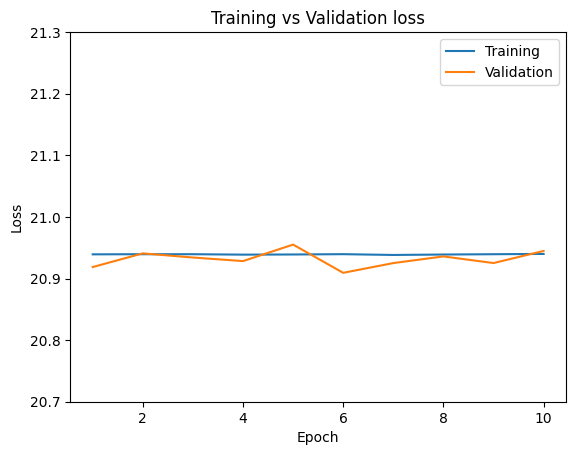

In [16]:
idx = np.arange(1, 11, 1)

plt.plot(idx, training_loss, label = "Training")
plt.plot(idx, validation_loss, label = "Validation")

plt.ylim(20.7, 21.3)

plt.title("Training vs Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()
plt.show()

#plt.savefig("train_valid_loss.png")

# Model save

In [17]:
torch.save(model.state_dict(), f="model_canberra")

# Model load

In [18]:
#model = mu.SiameseNeuralNetwork()
#model_path = torch.load(f="model_canberra")
#model.load_state_dict(model_path)